In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import special
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/MFG_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Solving Kolmogorov PDEs with NNs:
## A Monte Carlo Approach

In [2]:
class Mlp(nn.Module):
    """Simple multi-layer perceptron implementation."""
    def __init__(self, x_dim, layer_sizes, activation):
        """
        Creates an MLP with input dimension `x_dim` and number of hidden
        layers `len(layer_sizes)` where the i-th hidden layer has `layer_sizes[i]`
        hidden neurons.
        """
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(x_dim, layer_sizes[0]))
        self.layers.append(activation)
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.layers.append(activation)
        self.layers.append(nn.Linear(layer_sizes[-1], 1))
        
        for i in range(len(layer_sizes) + 1):
            nn.init.xavier_uniform_(self.layers[i * 2].weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Here we implement the Euler-Maruyama method to approximate the solution of an SDE. The scheme is given by

$$
    X_{t_{n+1}} = X_{t_n} + \mu(X_{t_n}) \Delta t_n + \sigma(X_{t_n}) \Delta W_n
$$

where $\Delta W_n \sim \mathcal{N}(0,\Delta t_n)$.

In [3]:
def euler_maruyama(x_0, t_vals, μ, σ):
    x = torch.clone(x_0)
    for i in range(len(t_vals) - 1):
        Δt = t_vals[i+1] - t_vals[i]
        ΔW = torch.normal(torch.zeros_like(x_0), torch.sqrt(Δt))
        x += μ(x) * Δt + σ(x) * ΔW
    return x

Here we implement the main training loop for our ML model to solve the PDE

$$
\frac{\partial}{\partial t} u(t, x) = \frac{1}{2}\frac{\partial^2}{\partial x^2} u(t,x)
$$

at time $T = 1$ with initial condition $u(0, x) = \sin\left(\sqrt{2} x\right)$. The analytic solution is given by $u(t, x) = e^{-t} \sin\left( \sqrt{2} x\right)$.

The SDE corresponding to the above Kolmogorov PDE is simply $dX_t = dW_t$. In other words

$$
\mu(x) = 0 \qquad \text{and} \qquad \sigma(x) = 1
$$


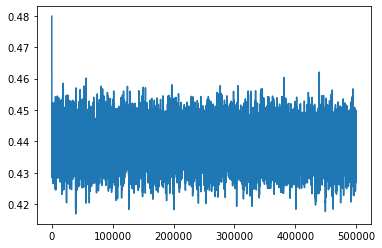

In [10]:
# Ininitialize NN architecture and optimizer
x_dim = 1
layer_sizes = [32]
model = Mlp(x_dim, layer_sizes, nn.Tanh())
optimizer = torch.optim.Adam(model.parameters())

# Define drift coeffs, volatility coeffs, and initial condition
μ = lambda x: torch.zeros_like(x)
σ = lambda x: torch.ones_like(x)
φ = lambda x: torch.sin(np.sqrt(2.0) * x)
# φ = lambda x: torch.square(x)

# Define the space/time region where we want to solve our PDE
left_endpoint = -1.0
right_endpoint = 1.0
x_0_sampler = torch.distributions.uniform.Uniform(left_endpoint, right_endpoint)
T = 1.0

batch_size = 64
n_epochs = int(5e5)
losses = []
for epoch in range(n_epochs):
    
    # Sample from space domain
    x_0 = x_0_sampler.sample([batch_size, x_dim])
    
    # Compute SDE trajectory with Euler-Maruyama
    t_tensor = torch.linspace(0.0, T, 2)
    S_N = euler_maruyama(x_0, t_tensor, μ, σ)
    
    # Compute Kolmogorov loss
    loss = torch.mean(torch.square(model(x_0) - φ(S_N)))
    
    # Take gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
window = 100
plt.plot(np.convolve(losses, np.ones(window)/window, mode='valid'))


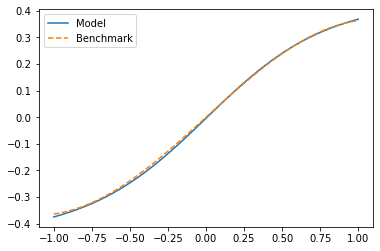

In [11]:
xs = torch.linspace(left_endpoint, right_endpoint, 100).view(-1, 1)
with torch.no_grad():
    model_output = model(xs)
# benchmark = xs**2 + T
benchmark = np.exp(-1.0) * np.sin(np.sqrt(2.0) * xs)

plt.plot(xs, model_output, xs, benchmark, '--')
plt.legend(['Model', 'Benchmark'])